# Müşteri Yaşam Boyu Değeri (Customer Lifetime Value)
- Bir müşterinin şirketle kurduğu ilişki-iletişim süresince bu şirkete kazandıracağı parasal değerdir. Bu değer hesaplandığı zaman müşterinin şirket ile kuracağı iletişim süresince şirkete kazandıracağı değer aşağı yukarı hesaplanmış olur.
- Peki bu niye önemlidir?
    - Müşterilerin gelecekte sağlayabileceği faydayı hesaplayabilirsek, hem onlarla olan ilişkimizi düzenleyebilir hem de şirkette müşteri odaklı yaklaşım sergilenebilir. Pazarlama odaklı bütçe belirlenmesinde rol oynoyacaktır.
- Nasıl hesaplanır? <br>
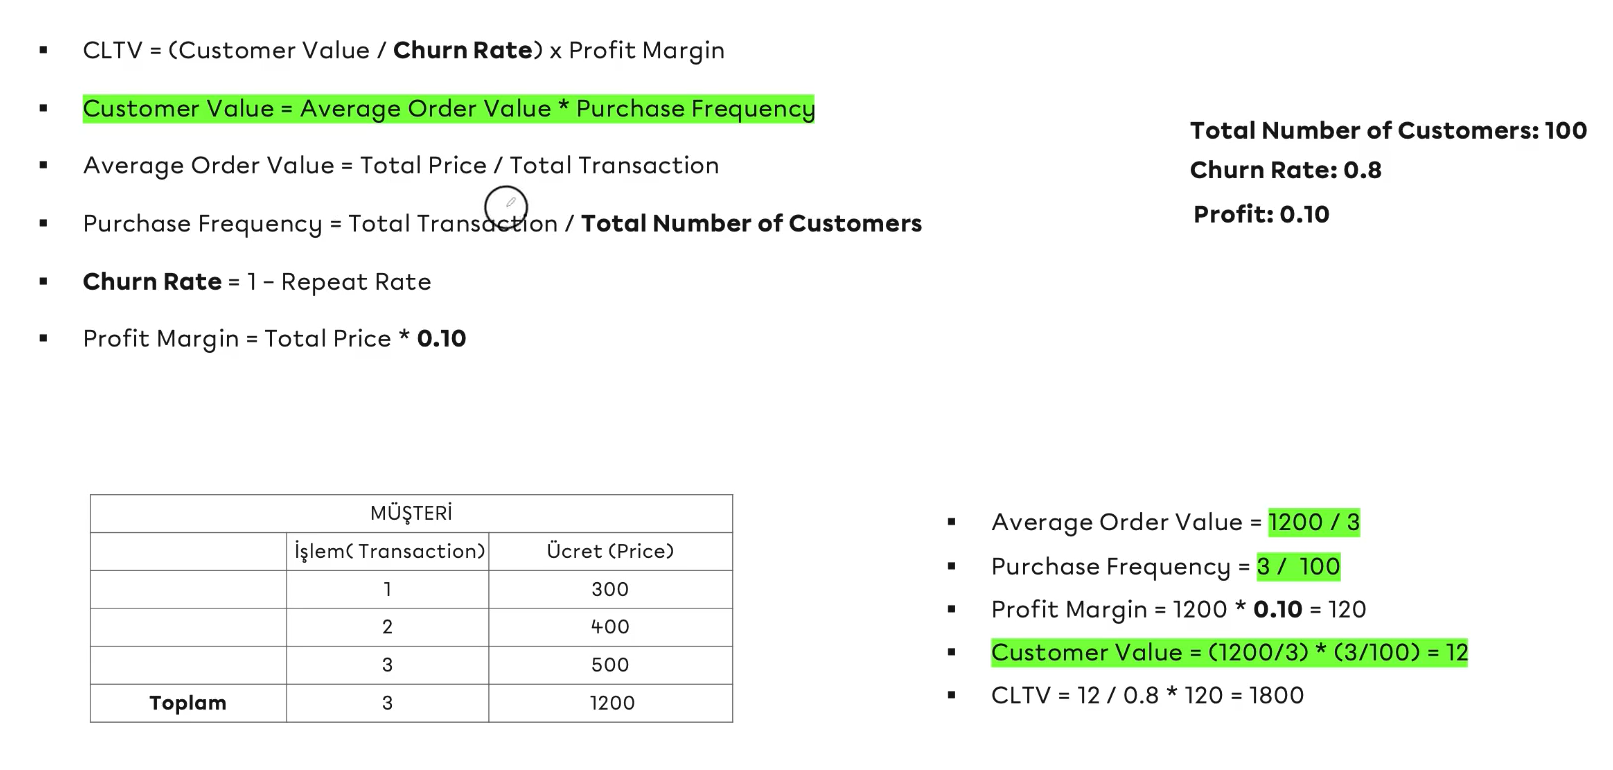
- Sonuç olarak her bir müşteri için hesaplanacak olan CLTV değerlerine göre bir sıralama yapıldığında ve CLTV değerlerine göre belirli noktalardan bölme işlemi yapılarak gruplar oluşturulduğunda müşterilerimiz segmentlere ayrılmış olacaktır.

# Proje Adımları
1. Veri Hazırlama
2. Average Order Value
3. Purchase Frequency
4. Repeat Rate & Churn Rate
5. Profit Margin
6. Customer Value
7. Customer Lifetime Value
8. Segmentlerin Oluşturulması
9. Tüm işlemin fonksiyonlaştırılması

### Attribute Information:

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

## 1. Veri Hazırlama

In [35]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [5]:
df_ = pd.read_excel("C:/Users/Acer/Desktop/DS-Bootcamp-main/crm/online_retail_II.xlsx", sheet_name="Year 2009-2010")

In [36]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [37]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [38]:
# İptal edilen işlemleri ve müşteri ID'si boş olan gözlemleri veri setinden çıkartalım.
df = df.loc[~df["Invoice"].str.contains("C", na=False)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,515255.00000,10.95663,104.35401,-9600.00000,1.00000,3.00000,10.00000,19152.00000
Price,515255.00000,3.95637,127.68856,-53594.36000,1.25000,2.10000,4.21000,25111.09000
Customer ID,407695.00000,15368.50411,1679.79570,12346.00000,13997.00000,15321.00000,16812.00000,18287.00000


In [39]:
df = df.dropna()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407695.00000,13.58669,96.84223,1.00000,2.00000,5.00000,12.00000,19152.00000
Price,407695.00000,3.29419,34.75666,0.00000,1.25000,1.95000,3.75000,10953.50000
Customer ID,407695.00000,15368.50411,1679.79570,12346.00000,13997.00000,15321.00000,16812.00000,18287.00000


- Yaptığımız 2 işlem ile veri setini uygulama yapılacak hale getirdik

In [40]:
df["Total_price"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom,83.40000
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom,81.00000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom,81.00000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom,100.80000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom,30.00000


- CLTV değerini hesaplamak için öncelikle her müşterinin yaptığı toplam harcamayı ve alışveriş sayısını bulmamız gerekiyor


In [41]:
cltv_c = df.groupby("Customer ID").agg({
        "Invoice": lambda Invoice: Invoice.nunique(),
        "Total_price": lambda Total_price: Total_price.sum(),
        "Quantity": lambda Quantity: Quantity.sum()
    })
cltv_c.head()

,Invoice,Total_price,Quantity
Customer ID,,,
12346.00000,11,372.86000,70
12347.00000,2,1323.32000,828
12348.00000,1,222.16000,373
12349.00000,3,2671.14000,993
12351.00000,1,300.93000,261


In [42]:
# Değişken isimlerini kolaylık sağlaması için değiştirelim
cltv_c.columns = ["total_transaction", "total_price", "total_unit"]
cltv_c.head()

,total_transaction,total_price,total_unit
Customer ID,,,
12346.00000,11,372.86000,70
12347.00000,2,1323.32000,828
12348.00000,1,222.16000,373
12349.00000,3,2671.14000,993
12351.00000,1,300.93000,261


## 2. Avarage Order Value (total price / total transaction)

In [43]:
cltv_c["avg_order_value"] = cltv_c["total_price"] / cltv_c["total_transaction"]
cltv_c.head()

,total_transaction,total_price,total_unit,avg_order_value
Customer ID,,,,
12346.00000,11,372.86000,70,33.89636
12347.00000,2,1323.32000,828,661.66000
12348.00000,1,222.16000,373,222.16000
12349.00000,3,2671.14000,993,890.38000
12351.00000,1,300.93000,261,300.93000


## 3. Purchase Frequency (total transaction / total number of customers)

In [44]:
cltv_c["purchase_frequency"] = cltv_c["total_transaction"] / len(cltv_c)
cltv_c.head()

,total_transaction,total_price,total_unit,avg_order_value,purchase_frequency
Customer ID,,,,,
12346.00000,11,372.86000,70,33.89636,0.00255
12347.00000,2,1323.32000,828,661.66000,0.00046
12348.00000,1,222.16000,373,222.16000,0.00023
12349.00000,3,2671.14000,993,890.38000,0.00070
12351.00000,1,300.93000,261,300.93000,0.00023


## 4. Repeat Rate & Churn Rate (Birden fazla alışveriş yapan müşteri sayısı / tüm müşteriler)

In [47]:
repeat_rate = len(cltv_c.loc[cltv_c["total_transaction"]>1]) / len(cltv_c)
churn_rate = 1 - repeat_rate
churn_rate

0.3293926750115902

## 5. Profit Margin (=total price * 0.10)
- Sabit şirket tarafından belirlenir

In [49]:
cltv_c["profit_margin"] = cltv_c["total_price"] * .1
cltv_c.head()

,total_transaction,total_price,total_unit,avg_order_value,purchase_frequency,profit_margin
Customer ID,,,,,,
12346.00000,11,372.86000,70,33.89636,0.00255,37.28600
12347.00000,2,1323.32000,828,661.66000,0.00046,132.33200
12348.00000,1,222.16000,373,222.16000,0.00023,22.21600
12349.00000,3,2671.14000,993,890.38000,0.00070,267.11400
12351.00000,1,300.93000,261,300.93000,0.00023,30.09300


## 6. Customer Value (avg_order_value * purchase_frequency)

In [54]:
cltv_c["customer_value"] = cltv_c["avg_order_value"] * cltv_c["purchase_frequency"]
cltv_c.head()

,total_transaction,total_price,total_unit,avg_order_value,purchase_frequency,profit_margin,customer_value
Customer ID,,,,,,,
12346.00000,11,372.86000,70,33.89636,0.00255,37.28600,0.08643
12347.00000,2,1323.32000,828,661.66000,0.00046,132.33200,0.30675
12348.00000,1,222.16000,373,222.16000,0.00023,22.21600,0.05150
12349.00000,3,2671.14000,993,890.38000,0.00070,267.11400,0.61918
12351.00000,1,300.93000,261,300.93000,0.00023,30.09300,0.06976


## 7. Customer Lifetime Value ((customer value / churn rate) * profit margin)

In [55]:
cltv_c["customer_lifetime_value"] = ((cltv_c["customer_value"] / churn_rate) * cltv_c["profit_margin"])
cltv_c.head()

,total_transaction,total_price,total_unit,avg_order_value,purchase_frequency,profit_margin,customer_value,customer_lifetime_value
Customer ID,,,,,,,,
12346.00000,11,372.86000,70,33.89636,0.00255,37.28600,0.08643,9.78357
12347.00000,2,1323.32000,828,661.66000,0.00046,132.33200,0.30675,123.23546
12348.00000,1,222.16000,373,222.16000,0.00023,22.21600,0.05150,3.47326
12349.00000,3,2671.14000,993,890.38000,0.00070,267.11400,0.61918,502.11041
12351.00000,1,300.93000,261,300.93000,0.00023,30.09300,0.06976,6.37290


In [56]:
cltv_c.sort_values("customer_lifetime_value", ascending=False)

,total_transaction,total_price,total_unit,avg_order_value,purchase_frequency,profit_margin,customer_value,customer_lifetime_value
Customer ID,,,,,,,,
18102.00000,89,349164.35000,124216,3923.19494,0.02063,34916.43500,80.93749,8579573.77276
14646.00000,78,248396.50000,170342,3184.57051,0.01808,24839.65000,57.57916,4342070.45829
14156.00000,102,196566.74000,108107,1927.12490,0.02364,19656.67400,45.56484,2719105.08615
14911.00000,205,152147.57000,69722,742.18327,0.04752,15214.75700,35.26833,1629055.80978
13694.00000,94,131443.19000,125893,1398.33181,0.02179,13144.31900,30.46898,1215855.89003
...,...,...,...,...,...,...,...,...
15913.00000,1,6.30000,3,6.30000,0.00023,0.63000,0.00146,0.00279
13788.00000,1,3.75000,1,3.75000,0.00023,0.37500,0.00087,0.00099
14095.00000,1,2.95000,1,2.95000,0.00023,0.29500,0.00068,0.00061


## 8. Segmentlerin Oluşturulması

In [57]:
cltv_c["segment"] = pd.qcut(cltv_c["customer_lifetime_value"], q=4, labels=["D", "C", "B", "A"])
cltv_c.head()

,total_transaction,total_price,total_unit,avg_order_value,purchase_frequency,profit_margin,customer_value,customer_lifetime_value,segment
Customer ID,,,,,,,,,
12346.00000,11,372.86000,70,33.89636,0.00255,37.28600,0.08643,9.78357,C
12347.00000,2,1323.32000,828,661.66000,0.00046,132.33200,0.30675,123.23546,B
12348.00000,1,222.16000,373,222.16000,0.00023,22.21600,0.05150,3.47326,D
12349.00000,3,2671.14000,993,890.38000,0.00070,267.11400,0.61918,502.11041,A
12351.00000,1,300.93000,261,300.93000,0.00023,30.09300,0.06976,6.37290,D


In [61]:
cltv_c.groupby("segment").agg({"count", "mean", "sum"})

total_transaction                  total_price                   \
                      sum     mean count           sum       mean count   
segment                                                                   
D                    1326  1.22892  1079  192265.13000  178.18826  1079   
C                    2160  2.00371  1078  513016.45300  475.89652  1078   
B                    4063  3.76902  1078 1219605.20000 1131.35918  1078   
A                   11666 10.81186  1079 6907116.49100 6401.40546  1079   

        total_unit                  avg_order_value                  \
               sum       mean count             sum      mean count   
segment                                                               
D           117616  109.00463  1079    169805.46550 157.37300  1079   
C           305135  283.05659  1078    317422.35514 294.45487  1078   
B           733211  680.15863  1078    420127.12365 389.72832  1078   
A          4383262 4062.33735  1079    723972.22347 670.96592  1079   

        purchase_frequency               profit_margin                  \
                       sum    mean count           sum      mean count   
segment                                                                  
D                  0.30737 0.00028  1079   19226.51300  17.81883  1079   
C                  0.50070 0.00046  1078   51301.64530  47.58965  1078   
B                  0.94182 0.00087  1078  121960.52000 113.13592  1078   
A                  2.70422 0.00251  1079  690711.64910 640.14055  1079   

        customer_value               customer_lifetime_value                    
                   sum    mean count                     sum        mean count  
segment                                                                         
D             44.56772 0.04130  1079              2849.32790     2.64071  1079  
C            118.91897 0.11031  1078             18184.26342    16.86852  1078  
B            282.70867 0.26225  1078            103549.86329    96.05739  1078  
A           1601.09330 1.48387  1079          25257295.04118 23408.05843  1079

In [62]:
cltv_c.to_csv("cltv_c.csv")

## 9. Tüm İşlemlerin Fonksiyonlaştırılması

In [63]:
def create_cltv_c(dataframe, profit=0.10):

    # Veriyi hazırlama
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[(dataframe['Quantity'] > 0)]
    dataframe.dropna(inplace=True)
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    cltv_c = dataframe.groupby('Customer ID').agg({'Invoice': lambda x: x.nunique(),
                                                   'Quantity': lambda x: x.sum(),
                                                   'TotalPrice': lambda x: x.sum()})
    cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']
    # avg_order_value
    cltv_c['avg_order_value'] = cltv_c['total_price'] / cltv_c['total_transaction']
    # purchase_frequency
    cltv_c["purchase_frequency"] = cltv_c['total_transaction'] / cltv_c.shape[0]
    # repeat rate & churn rate
    repeat_rate = cltv_c[cltv_c.total_transaction > 1].shape[0] / cltv_c.shape[0]
    churn_rate = 1 - repeat_rate
    # profit_margin
    cltv_c['profit_margin'] = cltv_c['total_price'] * profit
    # Customer Value
    cltv_c['customer_value'] = (cltv_c['avg_order_value'] * cltv_c["purchase_frequency"])
    # Customer Lifetime Value
    cltv_c['cltv'] = (cltv_c['customer_value'] / churn_rate) * cltv_c['profit_margin']
    # Segment
    cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])

    return cltv_c


df = df_.copy()

clv = create_cltv_c(df)

In [64]:
clv.head()

,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
Customer ID,,,,,,,,,
12346.00000,11,70,372.86000,33.89636,0.00255,37.28600,0.08643,9.78357,C
12347.00000,2,828,1323.32000,661.66000,0.00046,132.33200,0.30675,123.23546,B
12348.00000,1,373,222.16000,222.16000,0.00023,22.21600,0.05150,3.47326,D
12349.00000,3,993,2671.14000,890.38000,0.00070,267.11400,0.61918,502.11041,A
12351.00000,1,261,300.93000,300.93000,0.00023,30.09300,0.06976,6.37290,D
